# Correlate phantom and water measurements to get TOF

In this tutorial, we reconstruct the phantom speed-of-sound structure using linear straight-ray time of flight. The phantom data is from USCT data challenge https://usct.gitlab.io/datachallenge2019/data/.

First we import some functions.

In [13]:
import h5py
import obspy
from obspy.signal.cross_correlation import correlate, xcorr_max
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import linalg
import itertools
from tqdm import trange
import scipy
import straight_ray_tomo
import xarray as xr
from grid import *

plt.rcParams["font.family"] = "serif"
plt.rcParams.update({"font.size": 12})

### Utility functions

In [2]:
def get_sources_and_receivers(usctfile, read_waveforms=True):

    with h5py.File(usctfile, "r") as f:

        scans = {}
        for i, scan in enumerate(f["scans"].keys()):
            scans[scan] = {
                "emitter": np.array(f["scans"][scan]["emitter"]["location"]),
                "receiver": np.array(f["scans"][scan]["receiver"]["locations"]),
            }
            if read_waveforms:
                scans[scan]["waveforms"] = np.array(
                    f["scans"][scan]["receiver"]["waveforms"]
                )
                scans[scan]["sampling_rate"] = f["scans"][scan]["receiver"][
                    "waveforms"
                ].attrs["sampling_rate_in_hertz"]
                scans[scan]["start_time"] = f["scans"][scan]["receiver"][
                    "waveforms"
                ].attrs["start_time_in_seconds"]

        return scans


def get_all_source_receiver_pairs(scans):

    nrays = 0
    for i, scan in enumerate(scans):
        nrays += scans[scan]["receiver"].shape[0]
    sources = np.zeros([2, nrays])
    receivers = np.zeros([2, nrays])
    idx = 0
    for i, scan in enumerate(scans):
        nrays = scans[scan]["receiver"].shape[0]
        sources[:, idx : idx + nrays] = np.ones((2, nrays)) * scans[scan][
            "emitter"
        ].reshape((2, 1))
        receivers[:, idx : idx + nrays] = scans[scan]["receiver"].transpose()
        idx += nrays

    return sources, receivers

In [3]:
def get_traveltime_shifts(scans1, scans2):

    ntraces = 0
    for i, scan in enumerate(scans1):
        ntraces += scans1[scan]["receiver"].shape[0]
    traveltime_shift = np.zeros(
        [
            ntraces,
        ]
    )
    idx = 0
    for i, scan in enumerate(scans1):
        for trace in range(0, scans1[scan]["waveforms"].shape[1]):
            shift, value = xcorr_max(
                obspy.signal.cross_correlation.correlate(
                    scans1[scan]["waveforms"][:, trace],
                    scans2[scan]["waveforms"][:, trace],
                    1000,
                )
            )
            traveltime_shift[idx] = shift / scans1[scan]["sampling_rate"]
            idx += 1

    return traveltime_shift

In [4]:
def plot_Model(m, g, title=None, caxis=None):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    if not title == None:
        ax.set_title(title)

    plt.imshow(
        np.reshape(m, [g.x.shape[0], g.y.shape[0]]).T,
        extent=[
            g.x[0],
            g.x[0] + g.x.shape[0] * g.spacing,
            g.y[0],
            g.y[0] + g.y.shape[0] * g.spacing,
        ],
        cmap="gray",
    )
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    if caxis is not None:
        plt.clim(caxis)
    plt.colorbar(label="s [s/m]")


def plot_Lcurve(x_vals, y_vals, reg_param, title, a, secondTikhonov=False):
    colors = itertools.cycle(["gold", "orange", "red", "blueviolet"])
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(111)
    for i in range(len(x_vals)):
        if i in a:
            ax.plot(
                x_vals[i],
                y_vals[i],
                "o",
                label="$\\alpha$ = %.2f" % reg_param[i],
                color=next(colors),
                markersize=10,
            )
            ax.plot(x_vals[i], y_vals[i], "ko", fillstyle="none", markersize=10)
            ax.legend()
        else:
            ax.plot(x_vals[i], y_vals[i], "ko", fillstyle="none", markersize=10)
            ax.set_xlabel(
                "residual norm ||$\\mathbf{G}\\mathbf{m}_\\alpha-\\mathbf{d}$||$_2$",
                labelpad=15,
            )
            if secondTikhonov:
                ax.set_ylabel(
                    "solution norm ||$\\nabla^2\\mathbf{m}_\\alpha$||$_2$", labelpad=15
                )
            else:
                ax.set_ylabel(
                    "solution norm ||$\\mathbf{m}_\\alpha$||$_2$", labelpad=15
                )
        ax.set_title(title, pad=20)
    ax.grid()
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

Here, we load the data (the same phantom measurements also used for the B-mode imaging tutorial). 

In [5]:
phantom_measurements = "../Bmode/phantom_simple.h5"
water_measurements = "water.h5"
phantom_scans = get_sources_and_receivers(phantom_measurements)
water_scans = get_sources_and_receivers(water_measurements)

Next we calculate the travel time shifts, i.e. the difference between the first arrivals in the water and the phantom measurements, which is calculated via cross-correlation of the measurements. This is a widely used technique in common USCT devices to calibrate the sources, since by using relative traveltimes, i.e. travel time shifts instead of absolute travel times, any source characteristics from the waveforms that are unavoidably present due to imprecise placement of the transducers, hardware issues etc are removed.  

Text(0, 0.5, 'travel time shift [s]')

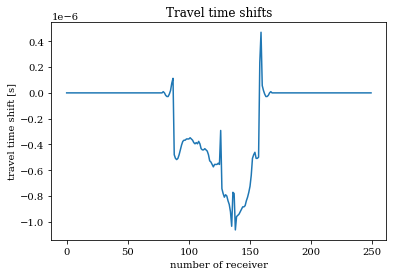

In [6]:
ttime_shifts = get_traveltime_shifts(phantom_scans, water_scans)
plt.plot(ttime_shifts[:250])
plt.title("Travel time shifts")
plt.xlabel("number of receiver")
plt.ylabel("travel time shift [s]")

## 1. Set up the geometry
### 1.1 Sources and receivers

To set up a straight-ray inversion, we need the source and receiver coordinates and we need to connect every source to all receivers via straight-rays. 

In [7]:
sources, receivers = get_all_source_receiver_pairs(water_scans)
sources = sources.T
receivers = receivers.T
print(sources.shape, receivers.shape)

# center the coordinates.
receivers[:, 1] -= 0.15
sources[:, 1] -= 0.15

(61752, 2) (61752, 2)


### 1.2 Computational domain and rectilinear grid

Here, we set up the rectilinear grid.

In [8]:
spacing = 0.0004
min_x = min(np.min(sources[:, 0]), np.min(receivers[:, 0]))
min_y = min(np.min(sources[:, 1]), np.min(receivers[:, 1]))
max_x = max(np.max(sources[:, 0]), np.max(receivers[:, 0]))
max_y = max(np.max(sources[:, 1]), np.max(receivers[:, 1]))

npoints = np.array(
    [int(np.ceil((max_x - min_x) / spacing)), int(np.ceil((max_y - min_y) / spacing))]
)

g = xr.Dataset(
    coords={
        "x": np.linspace(min_x, max_x, npoints[0], endpoint=True),
        "y": np.linspace(min_y, max_x, npoints[1], endpoint=True),
        "spacing": spacing,
    },
)

### 1.3 Compute straight-ray-tracing forward operator

Next, we set up the straight-ray-tracing matrix $\mathbf{G}$ that we need later in the inversions. $\mathbf{G}$ connects a slowness model $\mathbf{m}$ to our observed time-of-flight shifts $\mathbf{d}$. The number of rows of $\mathbf{G}$ is equal to the number of data points, thus to the number of rays that connect all source receiver pairs. The number of columns of $\mathbf{G}$ is equal to the unknowns in model space and thus to the number of pixels defined by the computational grid.

Matrix shape:             (61752, 245025)
Data points:              61752
Unknowns in model space:  245025
Non-zero entries:         24889305
Ratio of non-zeros:     0.1645 %


(<Figure size 432x432 with 2 Axes>,
 <AxesSubplot:title={'center':'spacing = 0.0004'}, xlabel='x [m]', ylabel='y [m]'>)

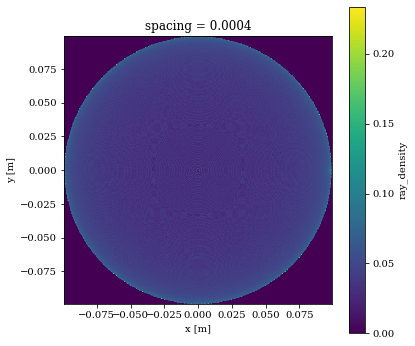

In [9]:
G = straight_ray_tomo.create_forward_operator(sources, receivers, g)
print("Matrix shape:            ", G.shape)
print("Data points:             ", G.shape[0])
print("Unknowns in model space: ", G.shape[1])
print("Non-zero entries:        ", G.count_nonzero())
print(
    "Ratio of non-zeros: {:10.4f} %".format(
        100 * G.count_nonzero() / (G.shape[0] * G.shape[1])
    )
)

straight_ray_tomo.plot_ray_density(G, g)

## 2. Inverse Problem setup
With the next lines, we will set up the linearized inverse problem that allows us to reconstruct the speed-of-sound map of the tissue mimicking phantom.

### 2.1 Initialize homogeneous background medium
As a prior in model space, we chose a homogeneous model with slowness values being equal to that of water (s=1/1500 s/m).

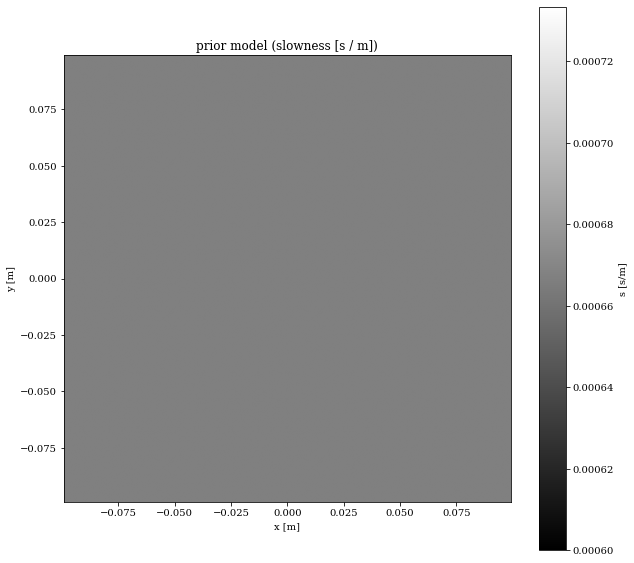

In [10]:
prior = 1500 * np.ones(npoints)
g["soundspeed"] = (["x", "y"], prior)
m_prior = (1 / np.array(g.data_vars["soundspeed"])).ravel()

plot_Model(m_prior, g, "prior model (slowness [s / m])")

## 3. Solve regularized least-squares Problem: **Damped least-squares**
In the following, we use a least-squares procedure that solves the linearized inverse problem
$$\min_{\mathbf{m}}\frac{1}{2}||\mathbf{G}\mathbf{m}-\mathbf{d}||_2^2+\alpha||\mathbf{m}||^2_2,$$
where $\mathbf{G}$ is the straight-ray-tacing forward matrix, $\mathbf{m}$ the model parametrized in slowness, $\mathbf{d}$ our observed time-of-flight shifts and $\alpha$ the regularization damping. With this, we obtain a reconstruction the slowness structure of the tissue. To tune the amount of prior information that is injected into the problem via the regularization term, we use an L-curve plot to visualize the contribution of the solution and the residual norm. Note that the regularization weight can be adjusted in `linalg.lsmr()` with the `damp` argument.

### 3.1 Tuning the regularization weight: L-curve plots

In [11]:
def L_curve_dampedLS(G, d, reg_param, m_prior):
    x_values = np.zeros(len(reg_param))
    y_values = np.zeros(len(reg_param))
    for i in trange(len(reg_param)):
        solution = scipy.sparse.linalg.lsmr(
            G, d, maxiter=600, show=False, damp=reg_param[i], atol=1e-8
        )
        m_rec_wf = m_prior - solution[0]
        x_values[i] = -np.linalg.norm(G.dot(m_rec_wf) - d)
        y_values[i] = np.linalg.norm(m_rec_wf - m_prior)
    return x_values, y_values

In [14]:
reg_param = np.array(
    [
        1e-4,
        5e-4,
        1e-3,
        2.5e-3,
        5e-3,
        7.5e-3,
        1e-2,
        2.5e-2,
        5e-2,
        7.5e-2,
        1e-1,
        2.5e-1,
        5e-1,
        7.5e-1,
        1.0,
        1.25,
        1.5,
    ]
)  # select a range of damping values to test
b = reg_param.shape[0]

x_values_dampedLS, y_values_dampedLS = L_curve_dampedLS(
    G, ttime_shifts, reg_param[:b], m_prior
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [02:08<00:00,  7.58s/it]


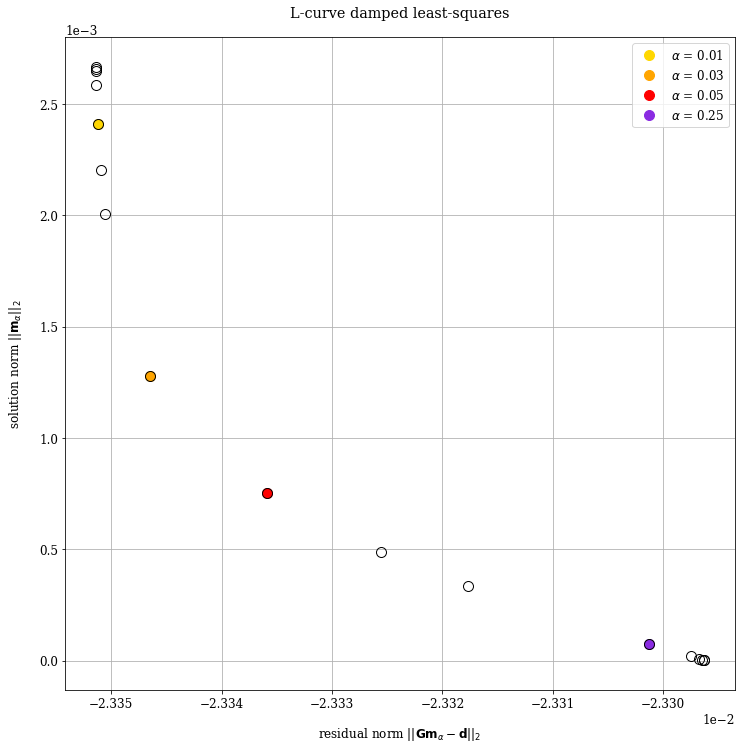

In [15]:
a = [4, 7, 8, 11]  # selected regularisation weigths are represented by colored dots
plot_Lcurve(
    x_values_dampedLS, y_values_dampedLS, reg_param, "L-curve damped least-squares", a
)

### 3.2 Invert for the phantom structure: **Damped least-squares**
Finally, we are ready to invert for the speed-of-sound structure using the damping values we select from the L-curve plot. Feel free to play around with this parameter and observe the effect of regularization on the reconstruction.

In [16]:
solution = linalg.lsmr(
    G, ttime_shifts, maxiter=600, show=True, damp=reg_param[7], atol=1e-12
)
m_rec_wf_dampedLS = m_prior + solution[0]

 
LSMR            Least-squares solution of  Ax = b

The matrix A has 61752 rows and 245025 columns
damp = 2.50000000000000e-02

atol = 1.00e-12                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =      600

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  8.390e-05  5.036e-06   1.0e+00  7.2e+02
     1  0.00000e+00  5.355e-05  1.521e-06   6.4e-01  3.9e-01  7.4e-02  1.3e+01
     2  0.00000e+00  4.371e-05  4.036e-07   5.2e-01  1.0e-01  9.0e-02  2.0e+01
     3  0.00000e+00  4.238e-05  1.359e-07   5.1e-01  3.3e-02  9.6e-02  2.6e+01
     4  0.00000e+00  4.223e-05  6.896e-08   5.0e-01  1.6e-02  1.0e-01  2.5e+01
     5  0.00000e+00  4.219e-05  2.442e-08   5.0e-01  5.1e-03  1.1e-01  2.5e+01
     6  0.00000e+00  4.219e-05  6.131e-09   5.0e-01  1.2e-03  1.2e-01  2.8e+01
     7  0.00000e+00  4.218e-05  2.093e-09   5.0e-01  4.1e-04  1.2e-01  2.8e+01
     8  0.00000e+00  4.218e-05  5.597e-10   5.0e-01  1.0e-04  1.3e-01  2.8e+0

Let's plot the result directly in speed of sound and not slowness.

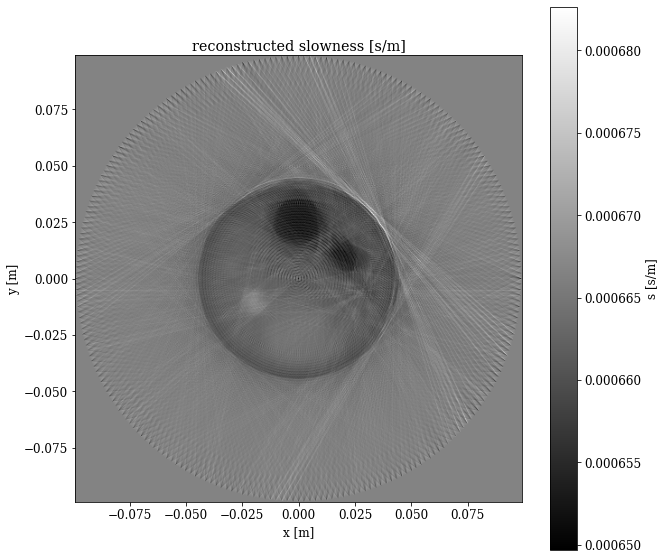

In [17]:
plot_Model(m_rec_wf_dampedLS, g, "reconstructed slowness [s/m]")

## 4. Solve regularized least-squares Problem: **second order Tikhonov**

In this section, we implement a second order Tikhonov regularization, which solves:
$$\min_{\mathbf{m}}\frac{1}{2}||\mathbf{G}\mathbf{m}-\mathbf{d}||_2^2+\alpha||\nabla^2\mathbf{m}||^2_2.$$

We start again with an L-curve plot in order to determin the regularization weight.

In [18]:
def L_curve_tikh(L, G, d, reg_param, m_prior):
    x_values = np.zeros(len(reg_param))
    y_values = np.zeros(len(reg_param))
    for i in trange(len(reg_param)):
        Gtilde = scipy.sparse.vstack([G, reg_param[i] * L])
        zeros = np.zeros(G.shape[1])
        d_tilde = np.hstack([d, zeros])

        solution = scipy.sparse.linalg.lsmr(
            Gtilde, d_tilde, maxiter=600, show=False, damp=0.0, atol=1e-8
        )
        m_rec_wf = m_prior - solution[0]
        x_values[i] = np.linalg.norm(Gtilde.dot(m_rec_wf) - d_tilde)
        y_values[i] = np.linalg.norm(L.dot(m_rec_wf - m_prior))
    return x_values, y_values

In [19]:
### Define FD second order derivative matrix
Dsecond_order = scipy.sparse.diags(
    [1, 1, -4, 1, 1],
    [-int(np.sqrt(G.shape[1])), -1, 0, 1, int(np.sqrt(G.shape[1]))],
    shape=(G.shape[1], G.shape[1]),
)
reg_param = np.array(
    [
        1e-4,
        5e-4,
        1e-3,
        2.5e-3,
        5e-3,
        7.5e-3,
        1e-2,
        2.5e-2,
        5e-2,
        7.5e-2,
        1e-1,
        2.5e-1,
        5e-1,
        7.5e-1,
        1.0,
        1.25,
        1.5,
    ]
)  # select a range of damping values to test
b = reg_param.shape[0]


### this takes quite a while to compute...
x_values_tikh, y_values_tikh = L_curve_tikh(
    Dsecond_order, G, ttime_shifts, reg_param[:], m_prior
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [27:37<00:00, 97.49s/it]


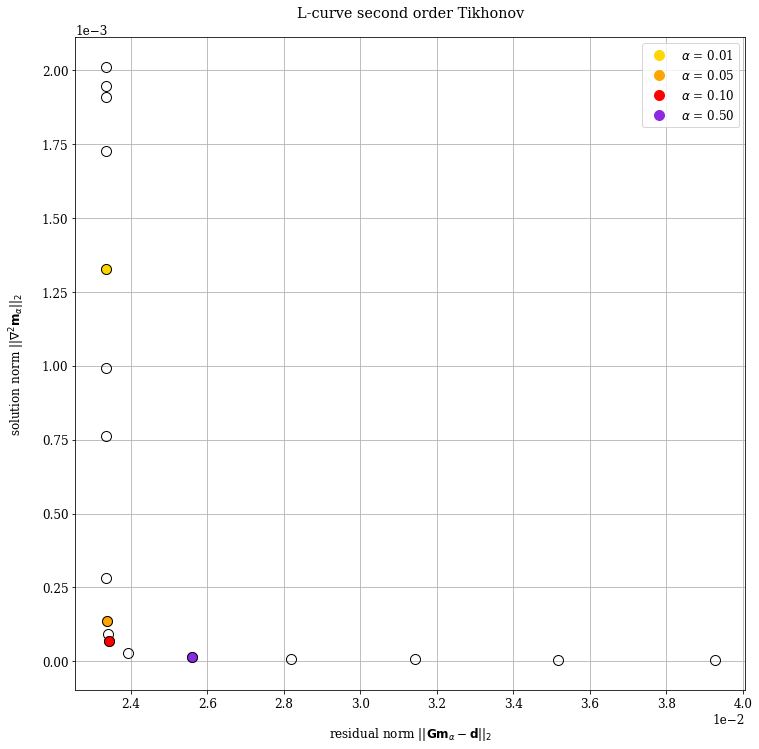

In [20]:
a = [4, 8, 10, 12]  # selected regularisation weigths are represented by colored dots
plot_Lcurve(
    x_values_tikh,
    y_values_tikh,
    reg_param,
    "L-curve second order Tikhonov",
    a,
    secondTikhonov=True,
)

### 4.2 Invert for the phantom structure: **Second order Tikhonov**
Again, we make use of the above L-curve to select meaningful values for the regularization parameter $\alpha$

In [21]:
Gtilde = scipy.sparse.vstack([G, reg_param[10] * Dsecond_order])
zeros = np.zeros(G.shape[1])
ttime_shifts_tilde = np.hstack([ttime_shifts, zeros])

In [22]:
### second derivative ###
solution = linalg.lsmr(
    Gtilde, ttime_shifts_tilde, maxiter=600, show=True, damp=0.0, atol=1e-8
)
m_rec_wf_tikh = m_prior + solution[0]

 
LSMR            Least-squares solution of  Ax = b

The matrix A has 306777 rows and 245025 columns
damp = 0.00000000000000e+00

atol = 1.00e-08                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =      600

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  8.390e-05  5.036e-06   1.0e+00  7.2e+02
     1  0.00000e+00  8.180e-05  4.856e-06   9.8e-01  6.0e-01  9.9e-02  1.0e+01
     2  0.00000e+00  7.521e-05  4.450e-06   9.0e-01  9.3e-02  6.4e-01  7.4e+00
     3  0.00000e+00  6.463e-05  3.742e-06   7.7e-01  6.7e-02  8.7e-01  4.9e+00
     4  0.00000e+00  5.485e-05  2.779e-06   6.5e-01  4.9e-02  1.0e+00  3.8e+00
     5  0.00000e+00  5.119e-05  2.120e-06   6.1e-01  3.5e-02  1.2e+00  3.1e+00
     6  0.00000e+00  5.002e-05  1.837e-06   6.0e-01  2.8e-02  1.3e+00  4.0e+00
     7  0.00000e+00  4.943e-05  1.730e-06   5.9e-01  2.5e-02  1.4e+00  6.0e+00
     8  0.00000e+00  4.883e-05  1.666e-06   5.8e-01  2.2e-02  1.5e+00  8.4e+

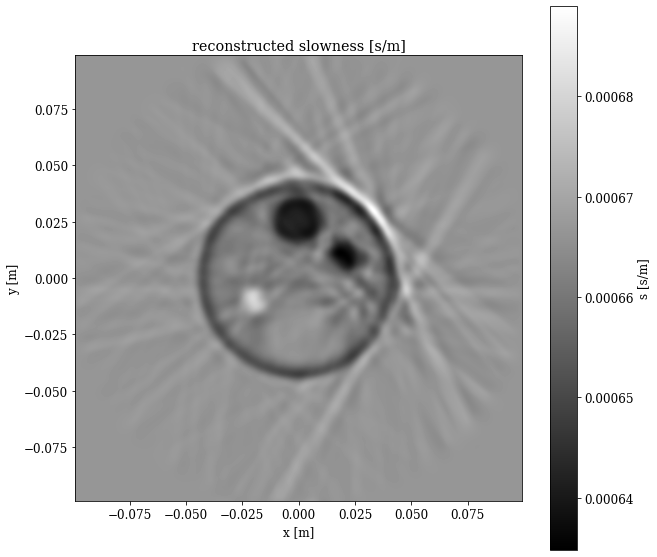

In [23]:
plot_Model(m_rec_wf_tikh, g, "reconstructed slowness [s/m]")